# Convolutional NN Model for Classification of the CIFAR-10 DataSet

## Introduction
The CIFAR-10 dataset consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. It has 10 categories of unrelated output labels: [0: Airplane, 1: Automobile, 2: Bird, 3: Cat, 4: Deer, 5: Dog, 6: Frog, 7: Horse, 8: Ship, 9: Truck].











### Imports

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import visualkeras
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications import EfficientNetV2L, ResNet50, ResNet50V2, ResNet152, ResNet152V2, EfficientNetB0
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
    GlobalAveragePooling2D,
)
from keras.metrics import F1Score
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical, plot_model
from time import time

### Loading the CIFAR-10 DataSet from Keras

In [2]:
(train_data, train_labels), (test_data, test_labels) = cifar10.load_data()

In [3]:
print(train_data.shape)
print(test_data.shape)

print(train_labels.shape)
print(test_labels.shape)

print(type(train_data))
print(type(test_data))

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Data Visualization

In [4]:
print(test_data[0][1])
print(test_data[0].shape)
print(test_labels[0][0])

[[152 112  51]
 [151 110  40]
 [159 114  45]
 [166 116  56]
 [162 112  49]
 [160 113  43]
 [164 117  47]
 [162 114  45]
 [163 116  46]
 [156 110  38]
 [155 111  41]
 [159 110  54]
 [163 113  52]
 [170 119  41]
 [171 117  40]
 [171 115  33]
 [169 115  30]
 [160 111  33]
 [154 112  41]
 [151 115  50]
 [145 110  53]
 [139 104  55]
 [140 102  52]
 [141 100  48]
 [149 105  50]
 [147 102  46]
 [145 102  45]
 [142  97  38]
 [143  98  34]
 [136  95  31]
 [125  91  32]
 [119  88  34]]
(32, 32, 3)
3


In [5]:
number_classes = len(set(test_labels.T[0]))
number_classes

10

There are 10 classes with the same amount of samples in the fashion_mnist dataset. Let's print their random examples.

In [6]:
class_names = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]

In [7]:
test_labels.T

array([[3, 8, 8, ..., 5, 1, 7]], dtype=uint8)

In [8]:
sorter = np.argsort(test_labels.T[0])
numbers = np.array([i for i in range(number_classes)])
indices = sorter[np.searchsorted(test_labels.T[0], numbers, sorter=sorter)]
test_images = test_data[indices]

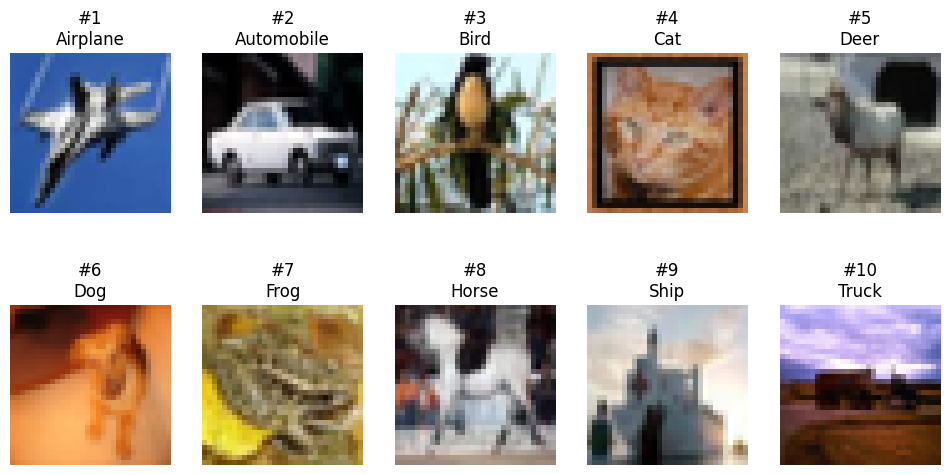

In [9]:
sorter = np.argsort(test_labels.T[0])
numbers = np.array([i for i in range(number_classes)])
indices = sorter[np.searchsorted(test_labels.T[0], numbers, sorter=sorter)]
test_images = test_data[indices]

plt.figure(figsize=(12, 6))
for i in range(number_classes):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"#{i+1}\n{class_names[i]}")
    plt.axis("off")
plt.show()

## Data Preparation

### Data Augmentation

In [10]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

### Data Normalization

In [11]:
X_train = train_data.astype("float32") / 255
X_test = test_data.astype("float32") / 255

y_train = to_categorical(train_labels, number_classes)
y_test = to_categorical(test_labels, number_classes)

### Resizing Data
Specify an integer multiplier in the range of 4

In [12]:
multiplier = 1
input_shape = (
    multiplier * test_data[0].shape[0],
    multiplier * test_data[0].shape[1],
    test_data[0].shape[2],
)

In [13]:
X_train = tf.image.resize(X_train, (input_shape[0], input_shape[1]))
X_test = tf.image.resize(X_test, (input_shape[0], input_shape[1]))

In [14]:
print(test_data.shape)
print(X_train.shape)

(10000, 32, 32, 3)
(50000, 32, 32, 3)


### Plotter of Learning Curves

In [15]:
def plot_results(history):
    history_dict = history.history

    epochs = range(1, len(history_dict["accuracy"]) + 1)

    plt.plot(epochs, history_dict["loss"], "bo", label="Training loss")
    plt.plot(epochs, history_dict["val_loss"], "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.plot(epochs, history_dict["accuracy"], "bo", label="Training acc"),
    plt.plot(epochs, history_dict["val_accuracy"], "b", label="Validation acc")
    plt.title("Training and validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

    """
    plt.plot(epochs, np.mean(history_dict["f1_score"], axis=1), "bo", label="Training F1 Score")
    plt.plot(epochs, np.mean(history_dict["val_f1_score"], axis=1), "b", label="Validation F1 Score")
    plt.title("Training and validation F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()
    """

### Plotter of Model's Score

In [16]:
def plot_score(total_results, per_class_accuracy, time_delta):
    print(f"\nDuration -> {time_delta:.1f}s")

    print("|__Metric__", end="")
    for i in range(10):
        print(f"|___{i}___", end="")
    print("|_Total_|")

    """
    print(f"|_F1_Score_", end="|")
    for i in range(10):
        print(f"_{np.mean(total_results[2][i])*100:.1f}%_", end="|")
    print(f"_{np.mean(total_results[2])*100:.1f}%_|")
    """

    print("|_Accuracy_", end="|")
    for i in range(10):
        print(f"_{per_class_accuracy[i]*100:.1f}%_", end="|")
    print(f"_{np.mean(total_results[1])*100:.1f}%_|")

### Model Evaluator

In [17]:
def evaluate_model(model, epochs=100, batch_size=64, name="cnn_86.keras"):
    start = time()

    checkpoint = ModelCheckpoint(
        name, monitor="val_accuracy", save_best_only=True, verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1
    )

    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size),
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint, reduce_lr],
    )

    results = model.evaluate(X_test, y_test)

    time_delta = time() - start

    per_class_accuracy = []
    for i in range(number_classes):
        res = model.evaluate(
            X_test[y_test.argmax(axis=1) == i],
            y_test[y_test.argmax(axis=1) == i],
        )
        per_class_accuracy.append(res[1])

    plot_score(results, per_class_accuracy, time_delta)

    plot_results(history)

    return history

## Study

### CNN Model with 4 Conv2D Layers + 2 Dense Layers

In [18]:
def construct_model_1(
    activation="relu",
    dropout_rate=0.3,
    initializer="he_normal",
    units_l1=128,
    units_l2=128,
    units_l3=256,
    units_l4=256,
    units_l5=512,
):
    model = Sequential(name="CNN")

    model.add(
        Conv2D(
            units_l1,
            3,
            padding="same",
            activation=activation,
            kernel_initializer=initializer,
            input_shape=(input_shape[0], input_shape[1], input_shape[2]),
            name="Conv_1",
        )
    )
    model.add(MaxPooling2D(pool_size=(2, 2), name="Pooling_1"))

    model.add(Conv2D(units_l2, 3, padding="same", activation=activation, name="Conv_2"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="Pooling_2"))

    model.add(BatchNormalization(name="BatchNorm_1"))
    model.add(Conv2D(units_l3, 3, padding="same", activation=activation, name="Conv_3"))
    model.add(Dropout(dropout_rate, name="Dropout_1"))

    model.add(Conv2D(units_l4, 3, padding="same", activation=activation, name="Conv_4"))
    model.add(MaxPooling2D(pool_size=(2, 2), name="Pooling_3"))
    model.add(Dropout(dropout_rate, name="Dropout_2"))

    model.add(Flatten())
    model.add(BatchNormalization(name="BatchNorm_2"))
    model.add(Dense(units_l5, activation=activation, name="Dense_1"))
    model.add(Dropout(dropout_rate, name="Dropout_3"))

    model.add(Dense(number_classes, activation="softmax", name="Dense_Output"))

    return model

In [19]:
def compile_model_1(model, optimizer=Adam, learning_rate=0.001):
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer(learning_rate=learning_rate),
        metrics=["accuracy"],
    )
    return model



Epoch 1/100


782/782 [==============================] - ETA: 0s - loss: 1.9321 - accuracy: 0.3599
Epoch 1: val_accuracy improved from -inf to 0.44100, saving model to cnn_86.keras
782/782 [==============================] - 81s 101ms/step - loss: 1.9321 - accuracy: 0.3599 - val_loss: 1.7201 - val_accuracy: 0.4410 - lr: 0.0010
Epoch 2/100
782/782 [==============================] - ETA: 0s - loss: 1.4622 - accuracy: 0.4699
Epoch 2: val_accuracy improved from 0.44100 to 0.53420, saving model to cnn_86.keras
782/782 [==============================] - 78s 100ms/step - loss: 1.4622 - accuracy: 0.4699 - val_loss: 1.3598 - val_accuracy: 0.5342 - lr: 0.0010
Epoch 3/100
782/782 [==============================] - ETA: 0s - loss: 1.3300 - accuracy: 0.5243
Epoch 3: val_accuracy improved from 0.53420 to 0.58960, saving model to cnn_86.keras
782/782 [==============================] - 76s 97ms/step - loss: 1.3300 - accuracy: 0.5243 - val_loss: 1.1913 - val_accuracy: 0.5896 - lr: 0.0010
Epoch 4/100
7

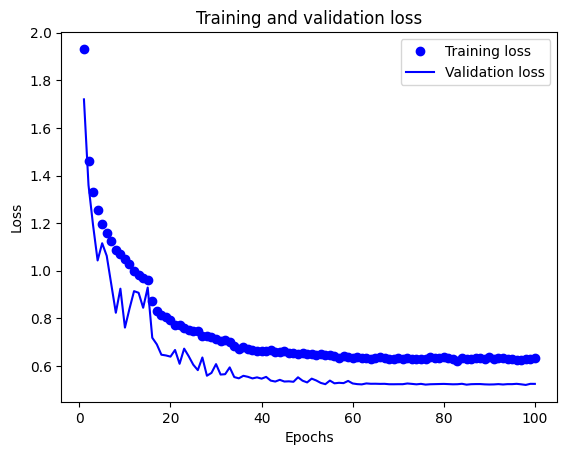

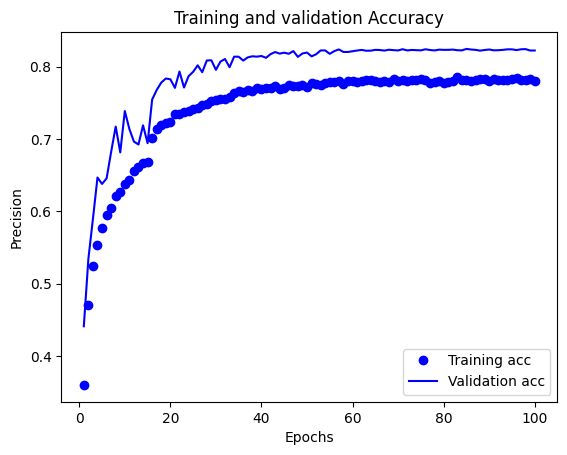

In [20]:
model_1 = construct_model_1()
model_1 = compile_model_1(model_1)
evaluate_model(model_1)

### Visualization of the Neural Network Architecture

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 Pooling_1 (MaxPooling2D)    (None, 16, 16, 128)       0         
                                                                 
 Conv_2 (Conv2D)             (None, 16, 16, 128)       147584    
                                                                 
 Pooling_2 (MaxPooling2D)    (None, 8, 8, 128)         0         
                                                                 
 BatchNorm_1 (BatchNormaliz  (None, 8, 8, 128)         512       
 ation)                                                          
                                                                 
 Conv_3 (Conv2D)             (None, 8, 8, 256)         295168    
                                                               

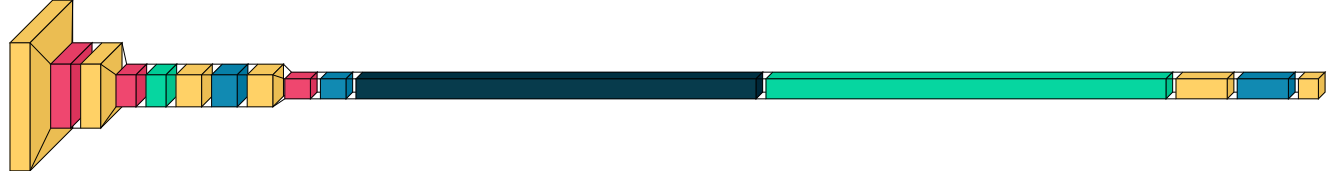

In [21]:
model_1.summary()
visualkeras.layered_view(model_1)